In [1]:
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import logging
import os
from main import run
from src.utils.config_setup import create_dirs
from src.datasets.data import Normalizer

In [2]:
ROOT = os.getcwd()

In [3]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)


In [4]:
model_file = 'SINDDataset_pretrained_2024-04-27_00-11-45_KIP'

index = 2
index_data = 0
folder = 'experiments'

In [6]:
import json

with open(f'{folder}/{model_file}/configuration.json') as f:
    config = json.load(f)
    config['save_dir'] = ROOT + f'/{folder}/' + config['save_dir'].split('/', index)[-1]
    config['output_dir'] = ROOT + f'/{folder}/' + config['output_dir'].split('/', index)[-1]  + '/eval'
    config['tensorboard_dir'] = ROOT + f'/{folder}/' + config['tensorboard_dir'].split('/', index)[-1] + '/eval'
    config['data_dir'] = ROOT + '/' + config['data_dir'].split('/', index_data)[-1]
    config['load_model'] = config['save_dir'] +'/model_best.pth'
    config['eval_only'] = True
    config['save_embeddings'] = True
    config['val_ratio'] = 1.0
    config['dropout'] = 0.0  # No dropout during evaluation
    config['hyperparameter_tuning'] = False

    create_dirs([config['output_dir']])
    
chunk_size =  config['data_chunk_len']

In [7]:
run(config)

2024-06-24 13:16:22,162 | INFO : Running:
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/ipykernel_launcher.py --f=/home/kfragkedaki/.local/share/jupyter/runtime/kernel-v2-1130mcA25MCFP1C1.json

2024-06-24 13:16:22,166 | INFO : Using device: cpu
2024-06-24 13:16:22,167 | INFO : Loading and preprocessing data ...
2024-06-24 13:16:22,168 | INFO : Loading 23 datasets files using 20 parallel processes ...


2024-06-24 13:16:22,958 | INFO : 10412 samples may be used for evaluation
2024-06-24 13:16:22,959 | INFO : 0 samples may be used for training
2024-06-24 13:16:22,960 | INFO : 10412 samples will be used for validation
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-06-24 13:16:23,234 | INFO : Model:
TSTransformerEncoder(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Non

Loaded model from /home/kfragkedaki/projects/Pedestrian_Project/experiments/SINDDataset_pretrained_2024-04-27_00-11-45_KIP/checkpoints/model_best.pth. Epoch: 28
Evaluating   0.0% | batch:         0 of        41	|	loss: 0.115583
Evaluating   2.4% | batch:         1 of        41	|	loss: 0.110607
Evaluating   4.9% | batch:         2 of        41	|	loss: 0.138799
Evaluating   7.3% | batch:         3 of        41	|	loss: 0.142788
Evaluating   9.8% | batch:         4 of        41	|	loss: 0.148016
Evaluating  12.2% | batch:         5 of        41	|	loss: 0.128356
Evaluating  14.6% | batch:         6 of        41	|	loss: 0.116696
Evaluating  17.1% | batch:         7 of        41	|	loss: 0.127928
Evaluating  19.5% | batch:         8 of        41	|	loss: 0.135958
Evaluating  22.0% | batch:         9 of        41	|	loss: 0.130322
Evaluating  24.4% | batch:        10 of        41	|	loss: 0.129571
Evaluating  26.8% | batch:        11 of        41	|	loss: 0.125431
Evaluating  29.3% | batch:        1

2024-06-24 13:16:34,046 | INFO : Evaluation Summary: loss: 0.131002 | 
2024-06-24 13:16:34,048 | INFO : Evaluation runtime: 0.0 hours, 0.0 minutes, 6.579187631607056 seconds



In [8]:
# Load the file
pt_file = torch.load(f"{folder}/{model_file}/eval/output_data.pt") # chunk 50, batch size 16, with original data
original_pt_file = torch.load(f"{folder}/{model_file}/eval/original_data.pt") # chunk 50, batch size 16, with original data

# Print the head of the file
print(pt_file.keys(), original_pt_file.keys())

dict_keys(['target_masks', 'targets', 'predictions', 'metrics', 'IDs', 'padding_masks', 'embeddings', 'embeddings_original']) dict_keys(['val_data'])


In [9]:
print(len(pt_file['embeddings'])) # (37, 256, 60, 128) -> number of batches, batch size, chunck size, embedding size
print(len(pt_file['embeddings'][0]))
print(len(pt_file['embeddings'][0][0]))
print(len(pt_file['embeddings'][0][0][0]))

41
256
50
128


In [10]:
max(original_pt_file['val_data'].index.unique()), original_pt_file['val_data'].shape

(10411, (483416, 6))

In [11]:
# Reshaping the DataFrame into a 3D list
result = []
feature_names = ["x", "y", "vx", "vy", "ax", "ay"]
padding_indicators = []

for key, group in original_pt_file['val_data'].groupby('data_chunk_len'):
    # For each group, convert it into a 2D list (where each sublist is a row in the group)
    chunks = group[feature_names].to_numpy()
    pad_length = chunk_size - chunks.shape[0]
    padded_chunks = np.pad(
        chunks,
        ((0, pad_length), (0, 0)),
        mode="constant",
        constant_values=0,
    )

     # Create an indicator array for padding
    # 0s for original data, 1s for padded data
    indicator_arr = np.zeros((chunks.shape[0], 1) , dtype=int)  # Initialize with zeros, indicating original data

    if pad_length > 0:
        # Create padding indicators (1s) and append to the original indicator array
        padding_indicator = np.ones((pad_length, 1), dtype=int)
        indicator_arr = np.vstack((indicator_arr, padding_indicator))
    
    padding_indicators.append(indicator_arr[:, 0])
    result.append(padded_chunks)


In [12]:
padding_indicators = np.array(padding_indicators)

In [13]:
all_data = np.concatenate(pt_file['targets'], axis=0)
all_data_original = np.array(result)
all_embeddings = np.concatenate(pt_file['embeddings'], axis=0)
all_embeddings_original = np.concatenate(pt_file['embeddings_original'], axis=0)
all_predictions = np.concatenate(pt_file['predictions'], axis=0)

padding_masks = np.concatenate(pt_file['padding_masks'], axis=0)
target_masks = np.concatenate(pt_file['target_masks'], axis=0)
padding_indicators = np.array(padding_indicators)

In [14]:
(padding_masks == (padding_indicators == 1)).sum()

0

# Predictions

In [15]:
import osmium as osm
from src.datasets.plot import SinDMap
from shapely.geometry import Point

In [16]:
map = SinDMap()

In [17]:
batch_id = padding_masks.shape[0] -1

In [18]:
all_data_original.shape, padding_masks.shape

((10412, 50, 6), (10412, 50))

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


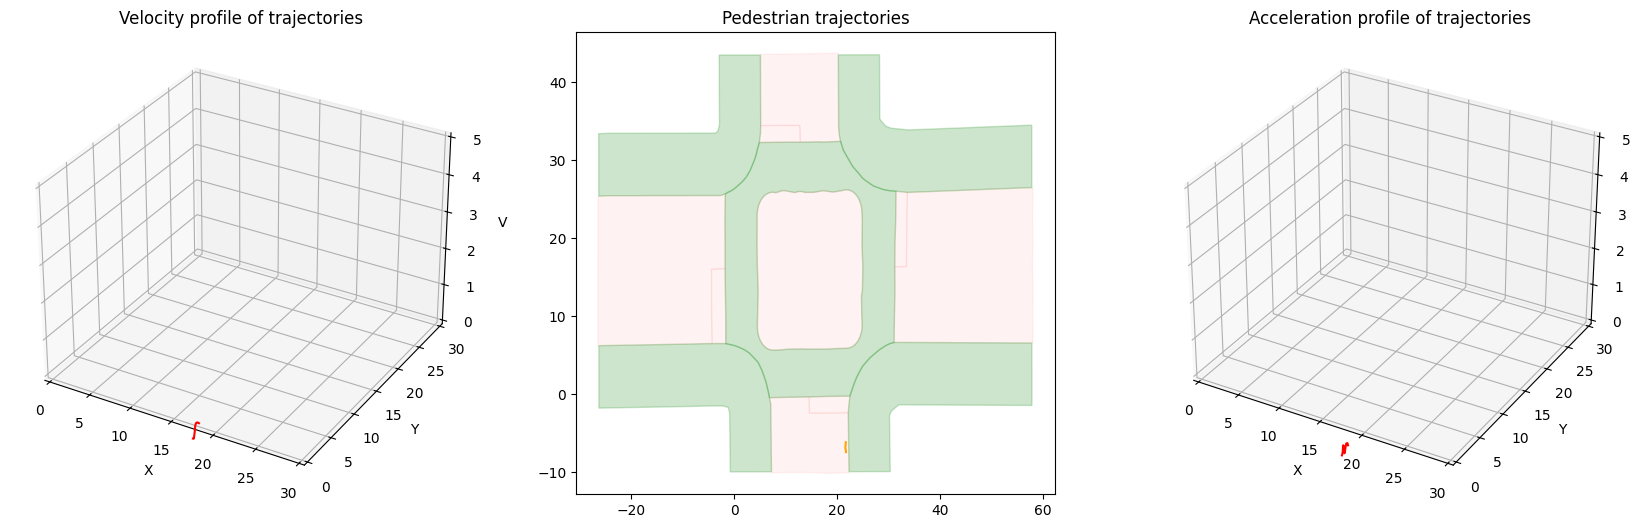

In [19]:
# orginal data (before normalization, if applied
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_data_original[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

In [20]:
# real_data = ~target_masks[batch_id][:, 0]*padding_masks[batch_id]
# real_data
real_data = (~target_masks*np.repeat(padding_masks[:, :, np.newaxis], 6, axis=2))
trained_data = (target_masks*np.repeat(padding_masks[:, :, np.newaxis], 6, axis=2))

In [21]:
(padding_masks[batch_id] == False).sum(), target_masks[batch_id][:, 0].sum(), (real_data[batch_id, :, 0] == False).sum(), (trained_data[batch_id, :, 0] == True).sum()

(35, 35, 35, 0)

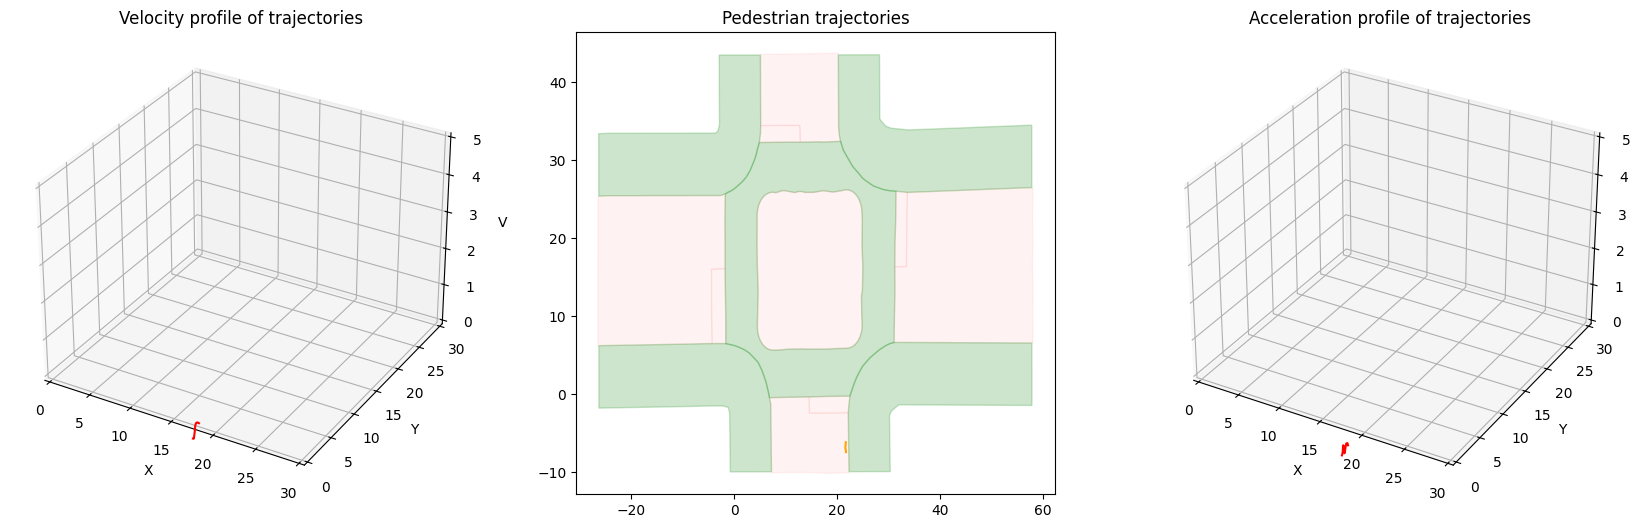

In [22]:
# target data (after normalization, if applied)
# config['data_normalization']  = "minmax"
if config['data_normalization'] != "none":
    normalizer = Normalizer(norm_type = config['data_normalization'])
    normalized_df = normalizer.normalize(all_data_original)
    map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(normalized_df[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_data[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=padding_masks)

In [23]:
# the padded data and the target are predicted correctly, the real data are not predicted correctly
real_data[batch_id, :, 0], padding_masks[batch_id]

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]))

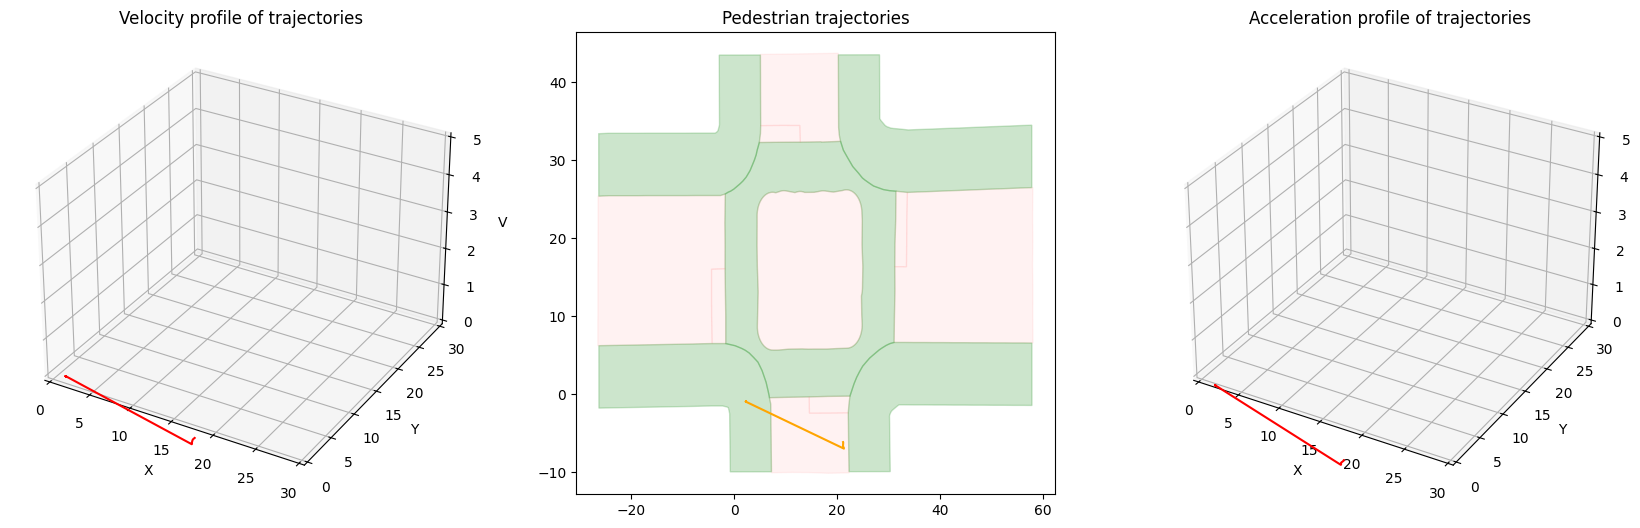

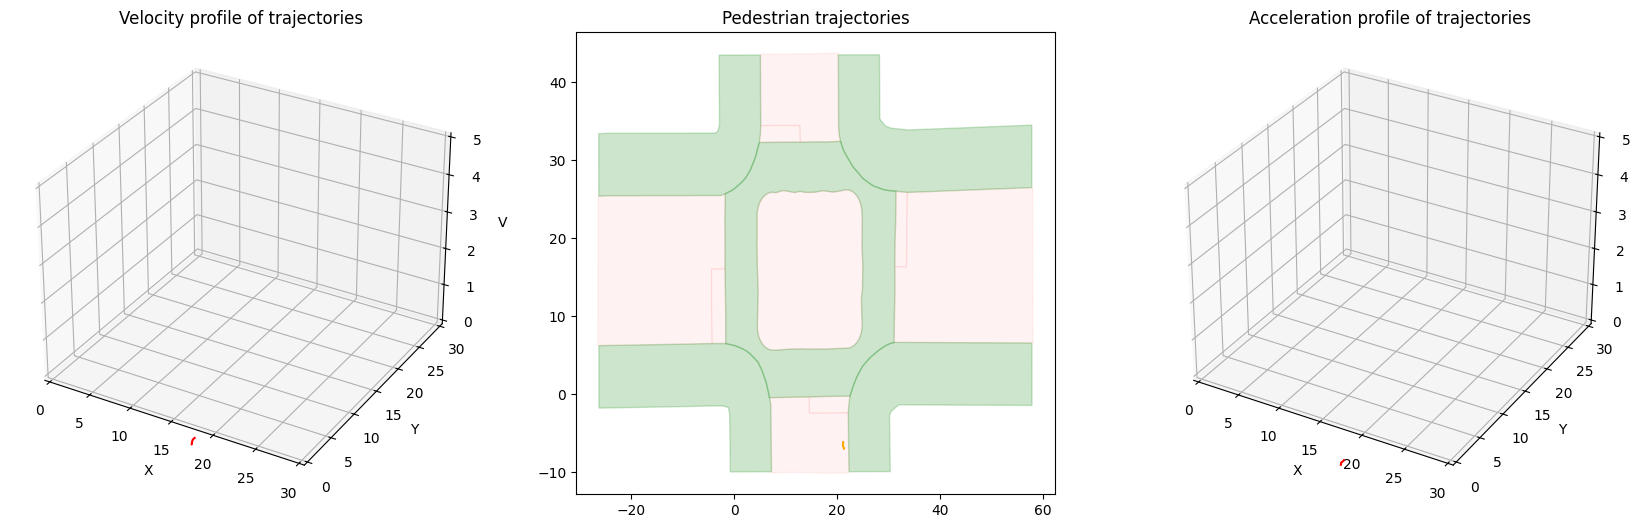

In [24]:
# predicted data before
# the padded data and the target are predicted correctly, the real data are not predicted correctly
if config['data_normalization'] != "none":
    original_df = normalizer.inverse_normalize(all_predictions)
    map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(original_df[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=~padding_masks)

map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_predictions[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])})
map.plot_single_data(pedestrian_data={batch_id: pd.DataFrame(all_predictions[batch_id], columns=["x", "y", "vx", "vy", "ax", "ay"])}, padding_masks=real_data[:, :,0])

# Create clusters

In [25]:
# Flatten the sequence_length and features dimensions
df_predicted = pd.DataFrame(all_embeddings.reshape(all_embeddings.shape[0], -1)) # flatten data merge first two dimensions
df_target = pd.DataFrame(all_data_original.reshape(all_data_original.shape[0], -1)) # flatten data merge first two dimensions
df_predicted.shape,  df_target.shape, all_embeddings.shape

((10412, 6400), (10412, 300), (10412, 50, 128))

### HDBSCAN

In [26]:
all_embeddings.shape,  all_data_original.shape

((10412, 50, 128), (10412, 50, 6))

In [27]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score

In [28]:
from sklearn.cluster import HDBSCAN

# Assuming embeddings is your array of shape (10948, 50, 128)
# Apply mean pooling across the time steps
data_pooled = np.mean(all_embeddings, axis=1)

# Cluster the data
hdbscan = HDBSCAN(min_cluster_size=5, min_samples=30)
clusters = hdbscan.fit_predict(data_pooled)

print("Cluster assignments:", len(set(clusters)))

Cluster assignments: 52


In [29]:
scores = { 'non_filtered' : {}, 'filtered' : {}}
best_score_filtered = -1
best_params_filtered = None

best_score = -1

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
if len(set(clusters)) - (1 if -1 in clusters else 0) > 1:
    print("Number of data unclustered vs clustered:", len(clusters[clusters == -1]), len(clusters))
    score = silhouette_score(data_pooled, clusters)
    scores['non_filtered']= score
    
    if score > best_score:
        best_score = score

    score_filtered = silhouette_score(data_pooled[clusters!=-1], clusters[clusters!=-1])
    scores['filtered'] = score_filtered

    if score_filtered > best_score_filtered:
        best_score_filtered = score_filtered

    print("Silhouette Score: ", score, "Filtered Silhouette Score: ", score_filtered, "num_clusters:", num_clusters)
else:
    print("Less than 2 clusters for eps:", eps, "min_samples:", min_samples, "num_clusters:", num_clusters)


Number of data unclustered vs clustered: 6868 10412
Silhouette Score:  -0.32509777 Filtered Silhouette Score:  0.5060117 num_clusters: 51


In [30]:
df_predicted['clusters'] = clusters
max(df_predicted['clusters']), min(df_predicted['clusters'])

(50, -1)

### Plot Trajectories (Starting+Ending point) based on Clustering

In [31]:
import matplotlib.cm as cm
cmap = cm.get_cmap('hsv')
num_clusters = max(df_predicted['clusters']) + 1
COLOR_PALETE = [cmap(i / num_clusters) for i in range(num_clusters)]

/tmp/ipykernel_87394/56373869.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


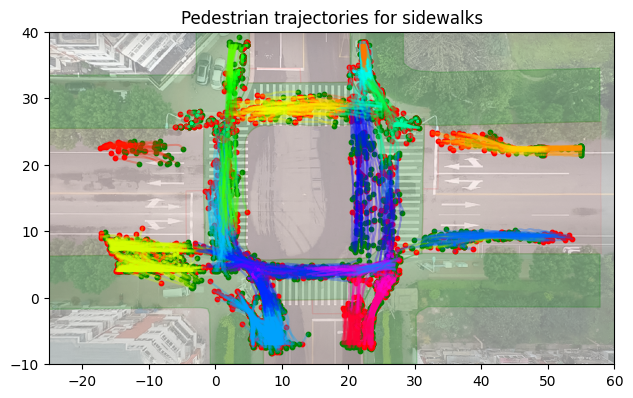

In [32]:
ax = map.plot_areas(alpha=0.2)
ax.set_title(f"Pedestrian trajectories for sidewalks" )

for cluster in df_predicted['clusters'][df_predicted['clusters']!=-1].unique():
    cluster_df = df_target[df_predicted['clusters'] == cluster]

    trajectories = {}
    for index, row in cluster_df.iterrows():
        trajectories[index] = row.values.reshape(-1, 6)
    
    map.plot_dataset(pedestrian_data=trajectories, ax=ax, color=COLOR_PALETE[cluster], title=f'cluster_{cluster}', alpha_trajectories=0.3, padding_masks=padding_masks)

# Clusters in Map

### Color Pallete

In [33]:
num_clusters = len(set(clusters))
# num_clusters = max(set(df_predicted['clusters'])) + 1 # len(set(clusters_df[key])) #

In [34]:
COLORS = ['#EF3D59', '#E17A47', '#EFC958', '#4AB19D',  '#344E5C', '#A6206A', '#568EA6', '#A2D4AB', '#5A5050']

In [35]:
# COLOR_PALETE = COLOR_PALETE + sns.color_palette("tab10", 20) + sns.color_palette("Pastel1", 20) + sns.color_palette("Dark2", 20) + sns.color_palette("hsv", 5)

In [36]:
import matplotlib.cm as cm
cmap = cm.get_cmap('hsv')
COLOR_PALETE = [cmap(i / num_clusters) for i in range(num_clusters)]

/tmp/ipykernel_87394/1599706044.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


### Split All Trajectories based on the Labels defined by Soderlund et al.

In [37]:
from src.reachability_analysis.labeling_oracle import LabelingOracleSINDData, LABELS

In [38]:
REVERSED_LABELS = {value: key for key, value in LABELS.items()}

In [39]:
labeling_oracle = LabelingOracleSINDData(config)
labeling_oracle.load_data()

2024-06-24 13:17:26,422 | INFO : Loading 23 datasets files using 20 parallel processes ...


In [40]:
all_data_original.shape, padding_masks.shape

((10412, 50, 6), (10412, 50))

In [41]:
df_predicted.shape, df_target.shape

((10412, 6401), (10412, 300))

In [42]:
labels = labeling_oracle.labels(all_data_original)
labels.shape

Labeling data:   0%|          | 0/10412 [00:00<?, ?it/s]

Labeling data: 100%|██████████| 10412/10412 [00:01<00:00, 8951.47it/s]


(10412,)

In [43]:
labels = pd.DataFrame(labels, columns=['label'])
df_dataset = pd.DataFrame(all_data_original.reshape(all_data_original.shape[0], -1))

In [44]:
trajectories = {feature: {} for feature in labels['label'].unique()}
trajectories_new = {feature: {} for feature in labels['label'].unique()}
padding_masked = {feature: {} for feature in labels['label'].unique()}
clusters_df = {feature: {} for feature in labels['label'].unique()}

for feature in labels['label'].unique():
    feature_df = df_dataset[labels['label'] == feature]
    padding_masked[feature] = padding_masks[labels['label'] == feature]
    clusters_df[feature] = clusters[labels['label'] == feature]

    for i, (index, row) in enumerate(feature_df.iterrows()):
        trajectories[feature][i] = row.values.reshape(-1, 6)
    
    for i, (index, row) in enumerate(feature_df[clusters_df[feature] != -1].iterrows()):
        trajectories_new[feature][i] = row.values.reshape(-1, 6)

/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/home/kfragkedaki/miniconda3/envs/pedestrian_project/lib/python3.9/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


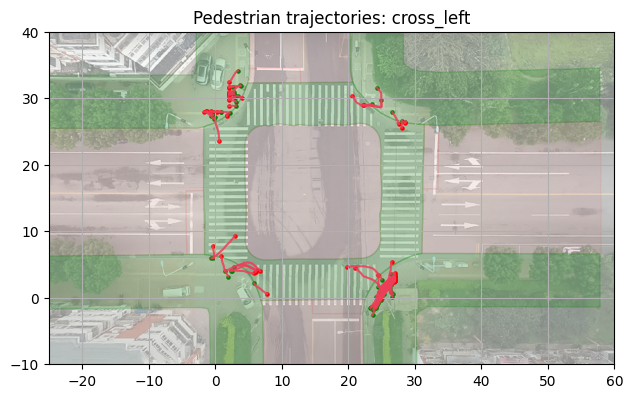

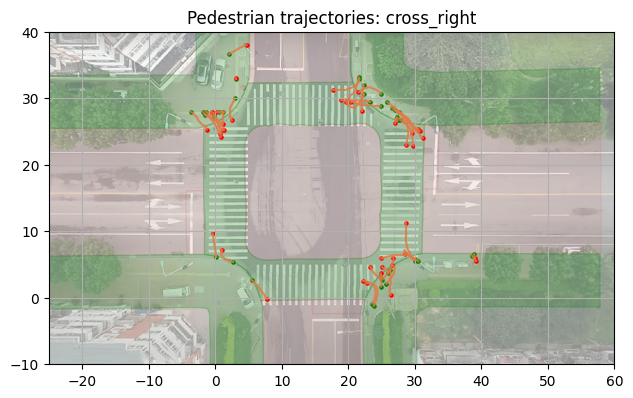

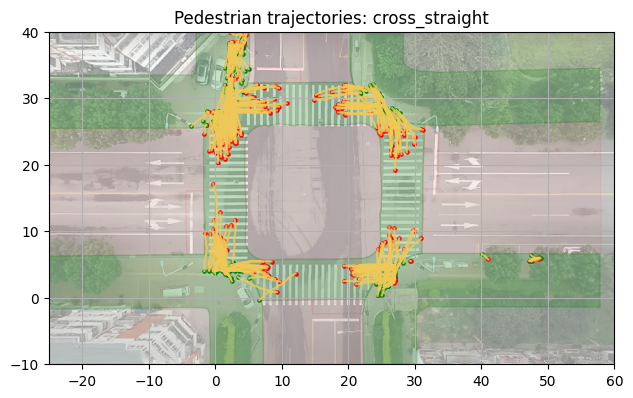

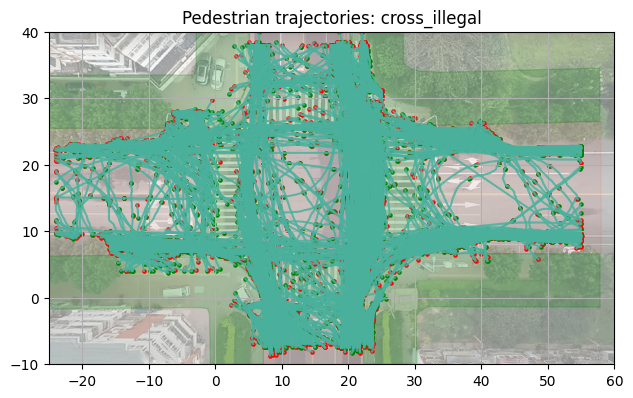

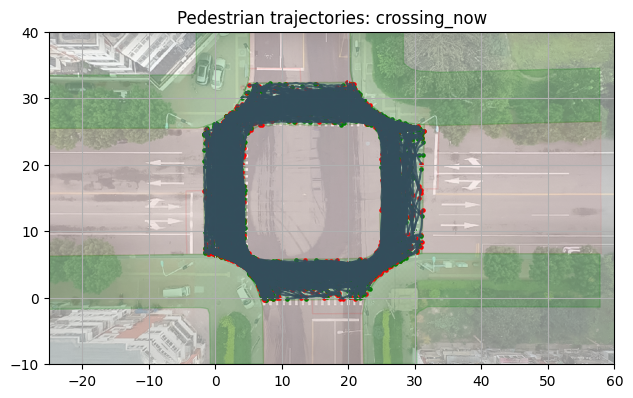

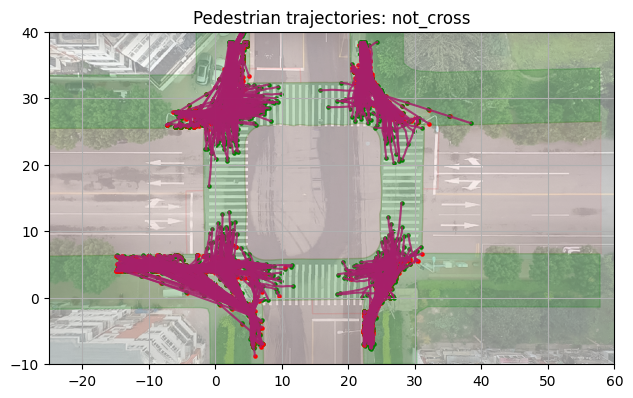

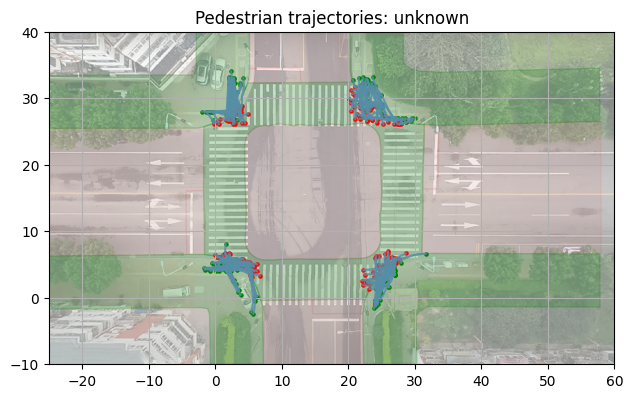

In [45]:
for key in REVERSED_LABELS.keys():
    labeling_oracle.map.plot_dataset(pedestrian_data=trajectories[key], color=COLORS[key], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=.85, size_points=5, padding_masks=padding_masked[key])

### PLot Trajectories based on the Predefined Labels - Color Trajectories based on the Cluster

In [46]:
REVERSED_LABELS

{0: 'cross_left',
 1: 'cross_right',
 2: 'cross_straight',
 3: 'cross_illegal',
 4: 'crossing_now',
 5: 'not_cross',
 6: 'unknown'}

In [47]:
key = 3
padding_masked[key].shape, clusters_df[key].shape, len(trajectories[key]), trajectories[key][0].shape

((4681, 50), (4681,), 4681, (50, 6))

In [48]:
# unique_clusters = len(set(clusters_df[key]))
# # Create the mapping from old values to consecutive new values
# mapping = {old_val: new_val for new_val, old_val in enumerate(sorted(unique_clusters))}

# clusters_df_new = pd.DataFrame(clusters_df[key])
# # Apply the mapping to the DataFrame column 'key'
# clusters_df_new = clusters_df_new[0].map(mapping)

# labeling_oracle.map.plot_dataset_color_clusters(pedestrian_data=trajectories_new[key], colors=COLOR_PALETE, clusters=clusters_df_new[clusters_df_new!= 0].to_numpy(), title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=0, padding_masks=padding_masked[key][clusters_df_new!= 0])

In [49]:
len(COLOR_PALETE), len(set(clusters_df[key]))#, len(mapping)

(52, 32)

In [50]:
len(clusters_df[key]), len(trajectories[key]), len(padding_masked[key])

(4681, 4681, 4681)

With Undefined Clusters (Cluster -1)

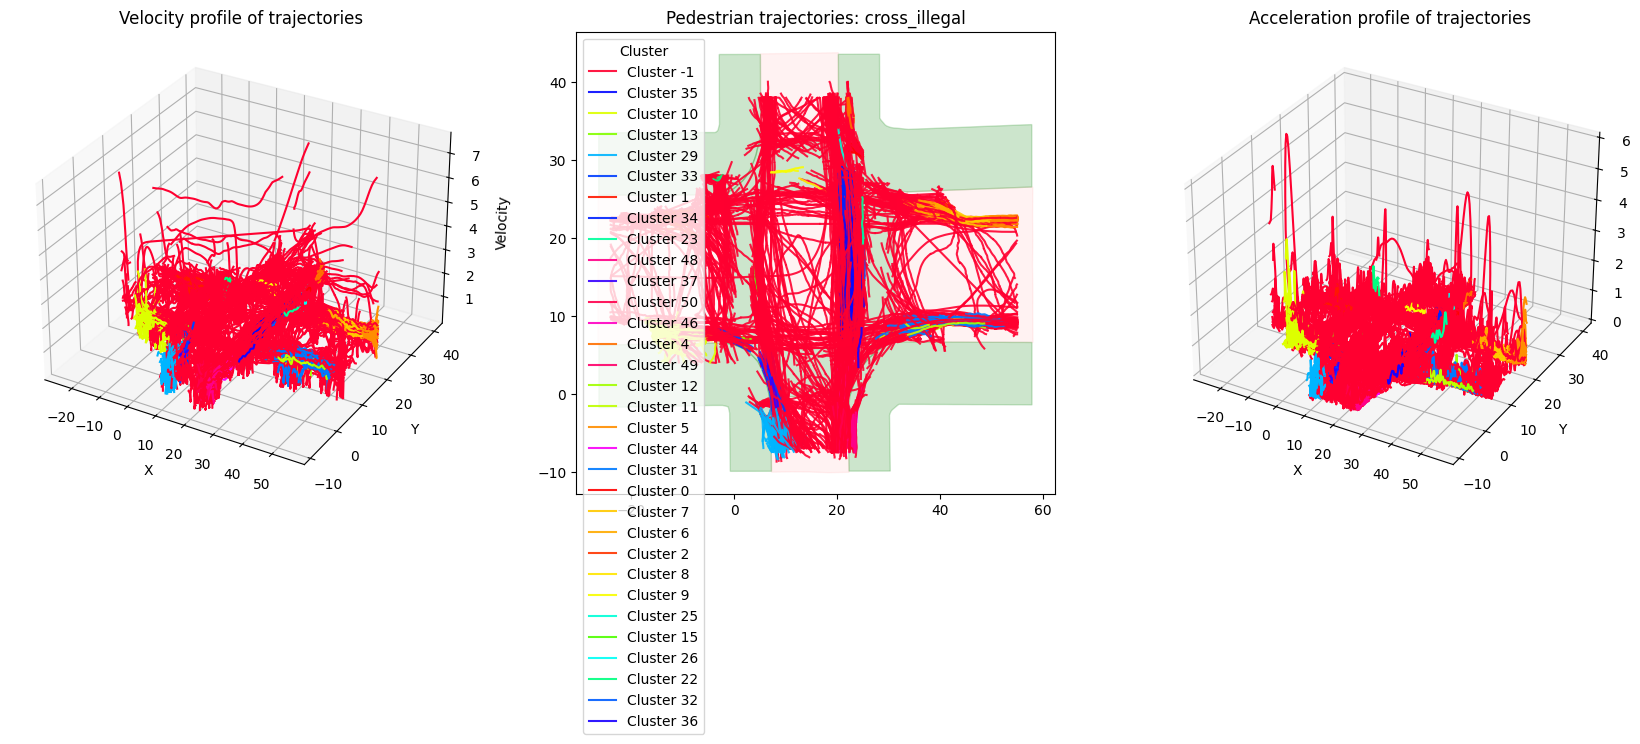

In [51]:
labeling_oracle.map.plot_dataset_color_clusters(pedestrian_data=trajectories[key], colors=COLOR_PALETE, clusters=clusters_df[key], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=0, padding_masks=padding_masked[key])

Without Undefined Clusters (Cluster != -1)

In [52]:
len(clusters_df[key][clusters_df[key]!= -1]), len(trajectories_new[key]), len(padding_masked[key][clusters_df[key]!= -1])

(1221, 1221, 1221)

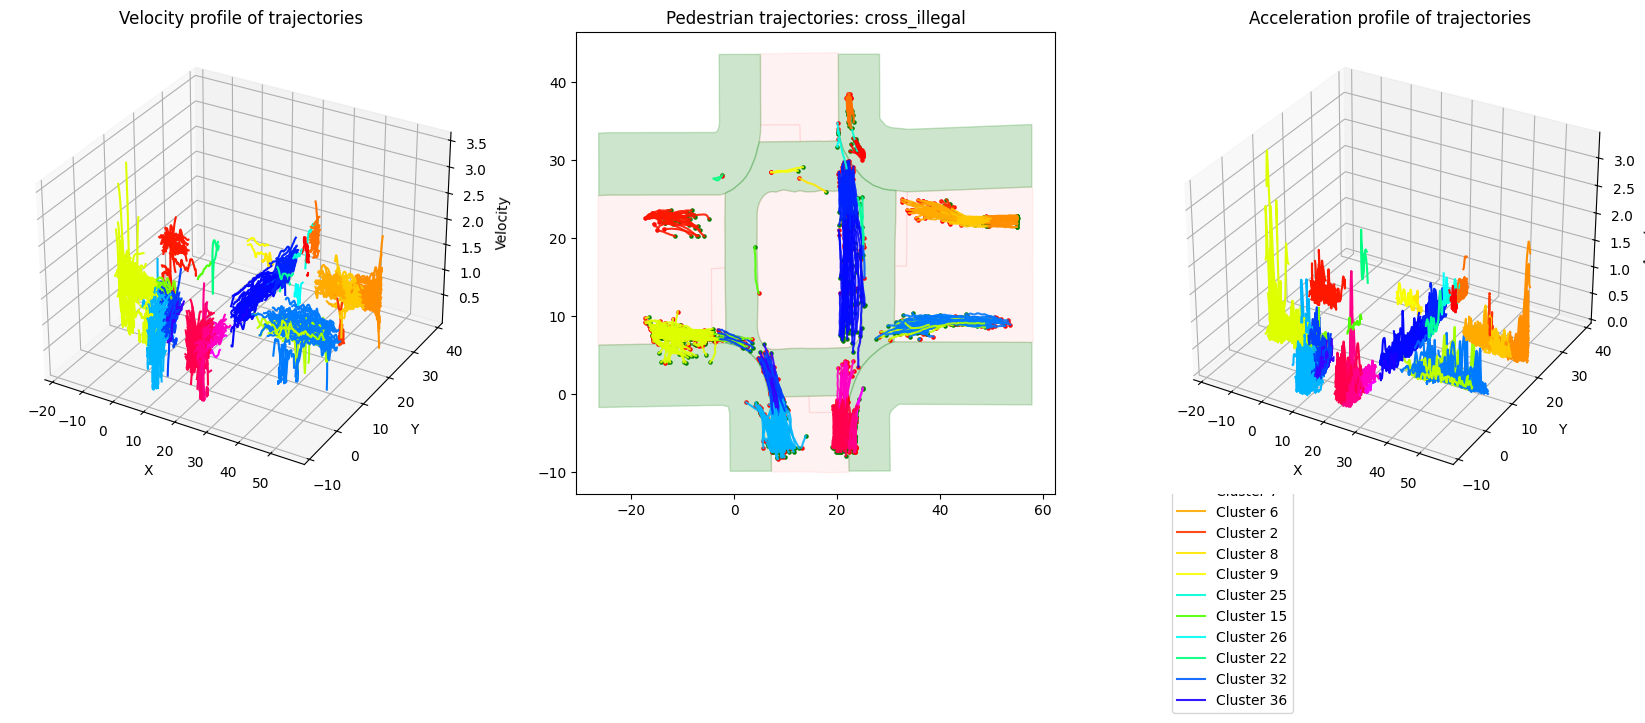

In [53]:
labeling_oracle.map.plot_dataset_color_clusters_all(pedestrian_data=trajectories_new[key], colors=COLOR_PALETE, clusters=clusters_df[key][clusters_df[key]!= -1], title=f'{REVERSED_LABELS[key]}', alpha_trajectories=0.9, size_points=5, padding_masks=padding_masked[key][clusters_df[key]!= -1])

### Plot the Distribution of Predefined Labels in a Cluster

In [54]:
data_pool_original = pd.DataFrame(np.mean(all_data_original, axis=1), columns=["x", "y", "vx", "vy", "ax", "ay"])
clusters_df_ = pd.DataFrame(clusters, columns=['cluster'])
labels_df = pd.DataFrame(labels, columns=['label'])
labels_df['label'] = labels_df['label'].map(pd.DataFrame(REVERSED_LABELS.values(), index=REVERSED_LABELS.keys())[0])

In [55]:
data_pool_original.shape, clusters_df_.shape, labels_df.shape

((10412, 6), (10412, 1), (10412, 1))

In [56]:
cluster_features = pd.concat([labels_df, clusters_df_, data_pool_original], axis=1)

In [57]:
# Aggregate data by cluster and category
category_counts = cluster_features.groupby(['cluster', 'label']).size().unstack(fill_value=0)

# Normalize the counts to get proportions within each cluster
category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)

In [58]:
# category_proportions_per_category = category_counts.div(category_counts.sum(axis=0), axis=1)

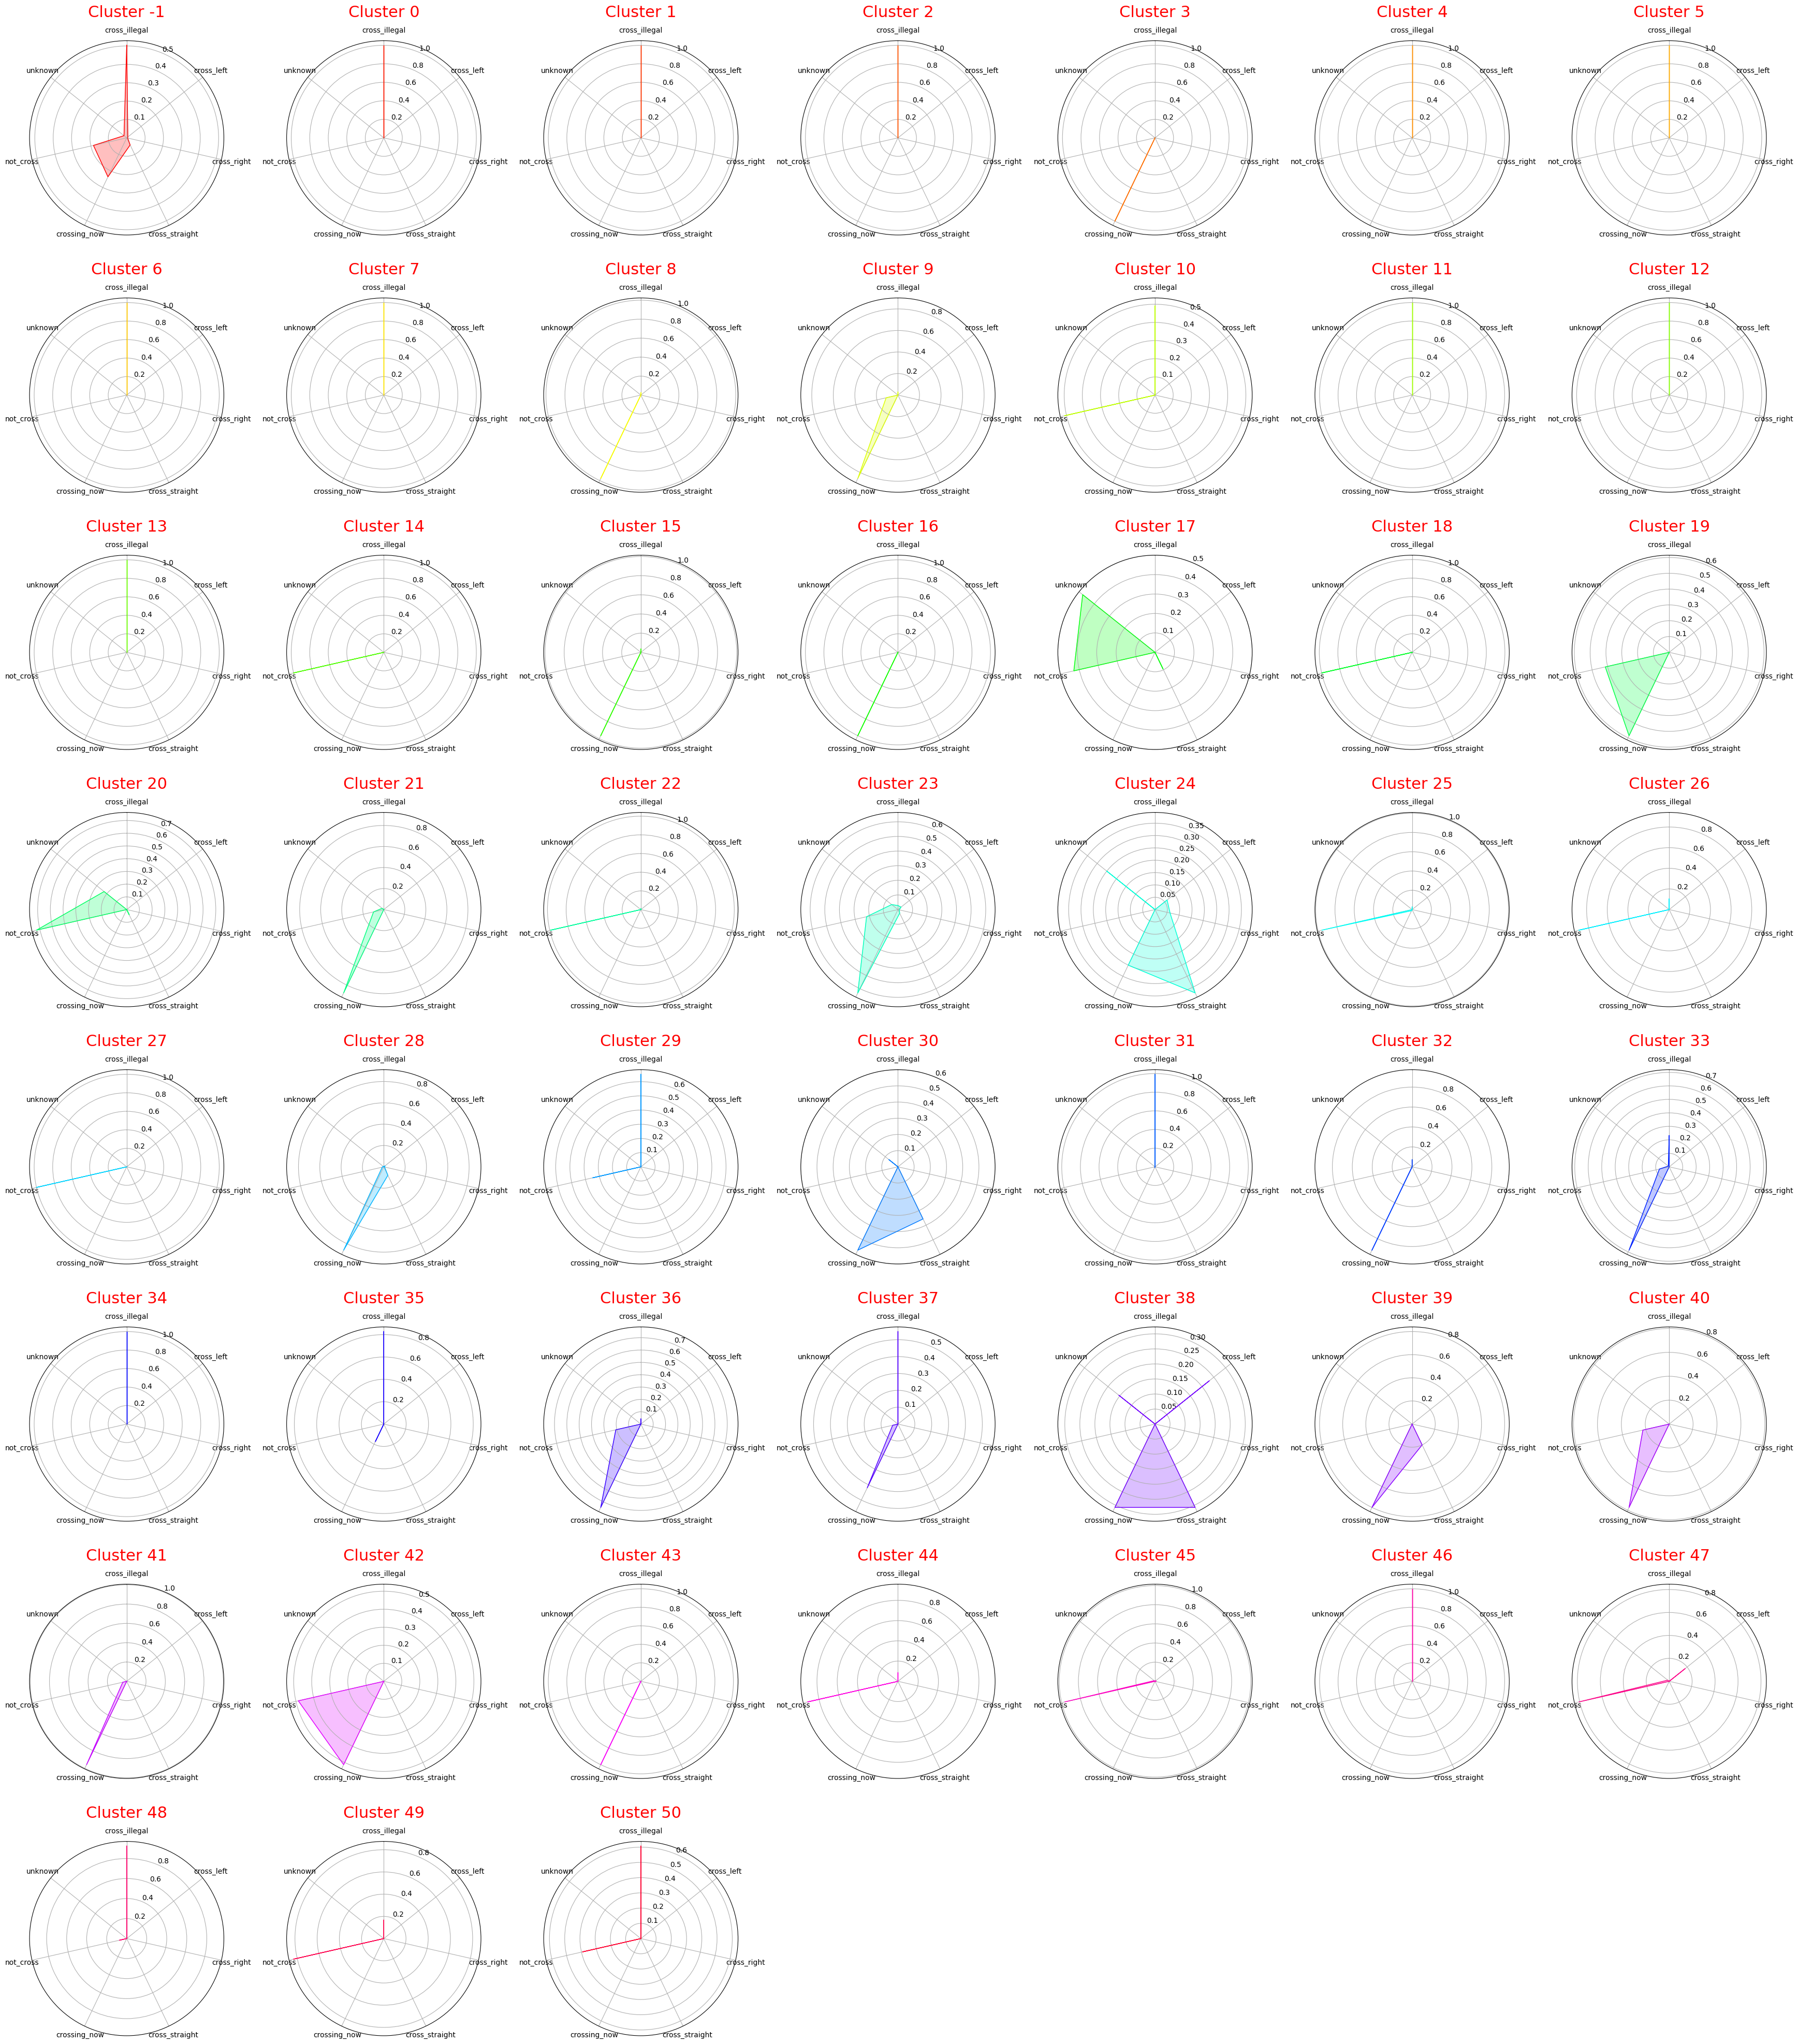

In [59]:
# Plotting Radar Chart 
def plot_radar_chart(ax, values, categories, title, color):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    values = values.tolist() + values.tolist()[:1]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    ax.plot(angles, values, color=color, linewidth=1, linestyle='solid', label=title)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(title, size=22, color='red', y=1.1)


# Set up the figure for radar charts
num_clusters = len(category_proportions)
cols = 7  # Max number of columns per row
rows = (num_clusters + cols - 1) // cols  # Calculate required number of rows
fig, axs = plt.subplots(figsize=(cols * 5, rows * 5), nrows=rows, ncols=cols, subplot_kw=dict(polar=True))
plt.rcParams.update({'font.size': 16})
axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

# Plot each cluster's radar chart
for i, (idx, row) in enumerate(category_proportions.iterrows()):
# for i, (idx, row) in enumerate(category_proportions_per_category.iterrows()):
    plot_radar_chart(axs[i], row, row.index, f'Cluster {idx}', color=COLOR_PALETE[i])

# Hide unused axes
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [60]:
# def add_radar_chart(ax, values, categories, title, color):
#     num_vars = len(categories)
#     angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
#     angles += angles[:1]  # Complete the loop

#     ax.set_theta_offset(np.pi / 2)
#     ax.set_theta_direction(-1)
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories)

#     values += values[:1]
#     ax.plot(angles, values, color=color, linewidth=1, linestyle='solid', label=title)
#     ax.fill(angles, values, color=color, alpha=0.25)
#     ax.set_title(title, size=15, color='red', y=1.1)

# def plot_clusters(features_df, num_clusters, colors, plot_labels=False):
#     # Columns per row
#     cols_per_row = 4
#     # Calculate number of rows needed
#     rows = (num_clusters + cols_per_row - 1) // cols_per_row  # Ceiling division

#     # Create subplots with dynamic rows and columns
#     fig, axs = plt.subplots(rows, cols_per_row, subplot_kw=dict(polar=True), figsize=(4 * cols_per_row, 4 * rows))
    
#     # Flatten axs array for easier iteration if it's multidimensional
#     if num_clusters > 1:
#         axs = axs.flatten()

#     for i in range(num_clusters):
#         if plot_labels:
#             categories = list(set(cluster_features['label']))
#             cluster_data = cluster_features[cluster_features['cluster'] == 3-1]['label'].value_counts().reindex(categories, fill_value=0)
#         else:
#             categories = list(features_df.columns[2:])  # assuming the first two columns are 'label' and 'cluster'
#             cluster_data = features_df[features_df['cluster'] == i-1][categories].mean()  # mean of each feature in this cluster
#         add_radar_chart(axs[i], cluster_data[categories].tolist(), categories, f'Cluster {i-1}', color=colors[i])

#     # Hide any unused subplots
#     for ax in axs[num_clusters:]:
#         ax.set_visible(False)

#     plt.tight_layout()
#     plt.show()

# plot_clusters(cluster_features, len(set(clusters_df_['cluster'])), colors=COLOR_PALETE)